## Colored point cloud registration
This tutorial demonstrates an ICP variant that uses both geometry and color for registration. It implements the algorithm of [Park2017](http://www.open3d.org/docs/release/tutorial/reference.html#park2017). The color information locks the alignment along the tangent plane. Thus this algorithm is more accurate and more robust than prior point cloud registration algorithms, while the running speed is comparable to that of ICP registration. This tutorial uses notations from ICP registration.

### Helper visualization function
In order to demonstrate the alignment between colored point clouds, ***draw_registration_result_original_color*** renders point clouds with their original color.

In [1]:
import open3d as o3d
import numpy as np 
import matplotlib.pyplot as plt 
import copy
import Open3D.examples.python.open3d_tutorial as o3dtut
import time

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


ModuleNotFoundError: No module named 'Open3D'

In [6]:
def draw_registration_result_original_color(source, target, transformation):
    source_temp = copy.deepcopy(source)
    source_temp.transform(transformation)
    o3d.visualization.draw_geometries([source_temp, target],
                                        zoom=0.5,
                                        front=[-0.2458, -0.8088, 0.5342],
                                        lookat=[1.7745, 2.2305, 0.9787],
                                        up=[0.3109, -0.5878, -0.7468])

### Input
The code below reads a source point cloud and a target point cloud from two files. An identity matrix is used as initialization for the registration.

1. Load two point clouds and show initial pose


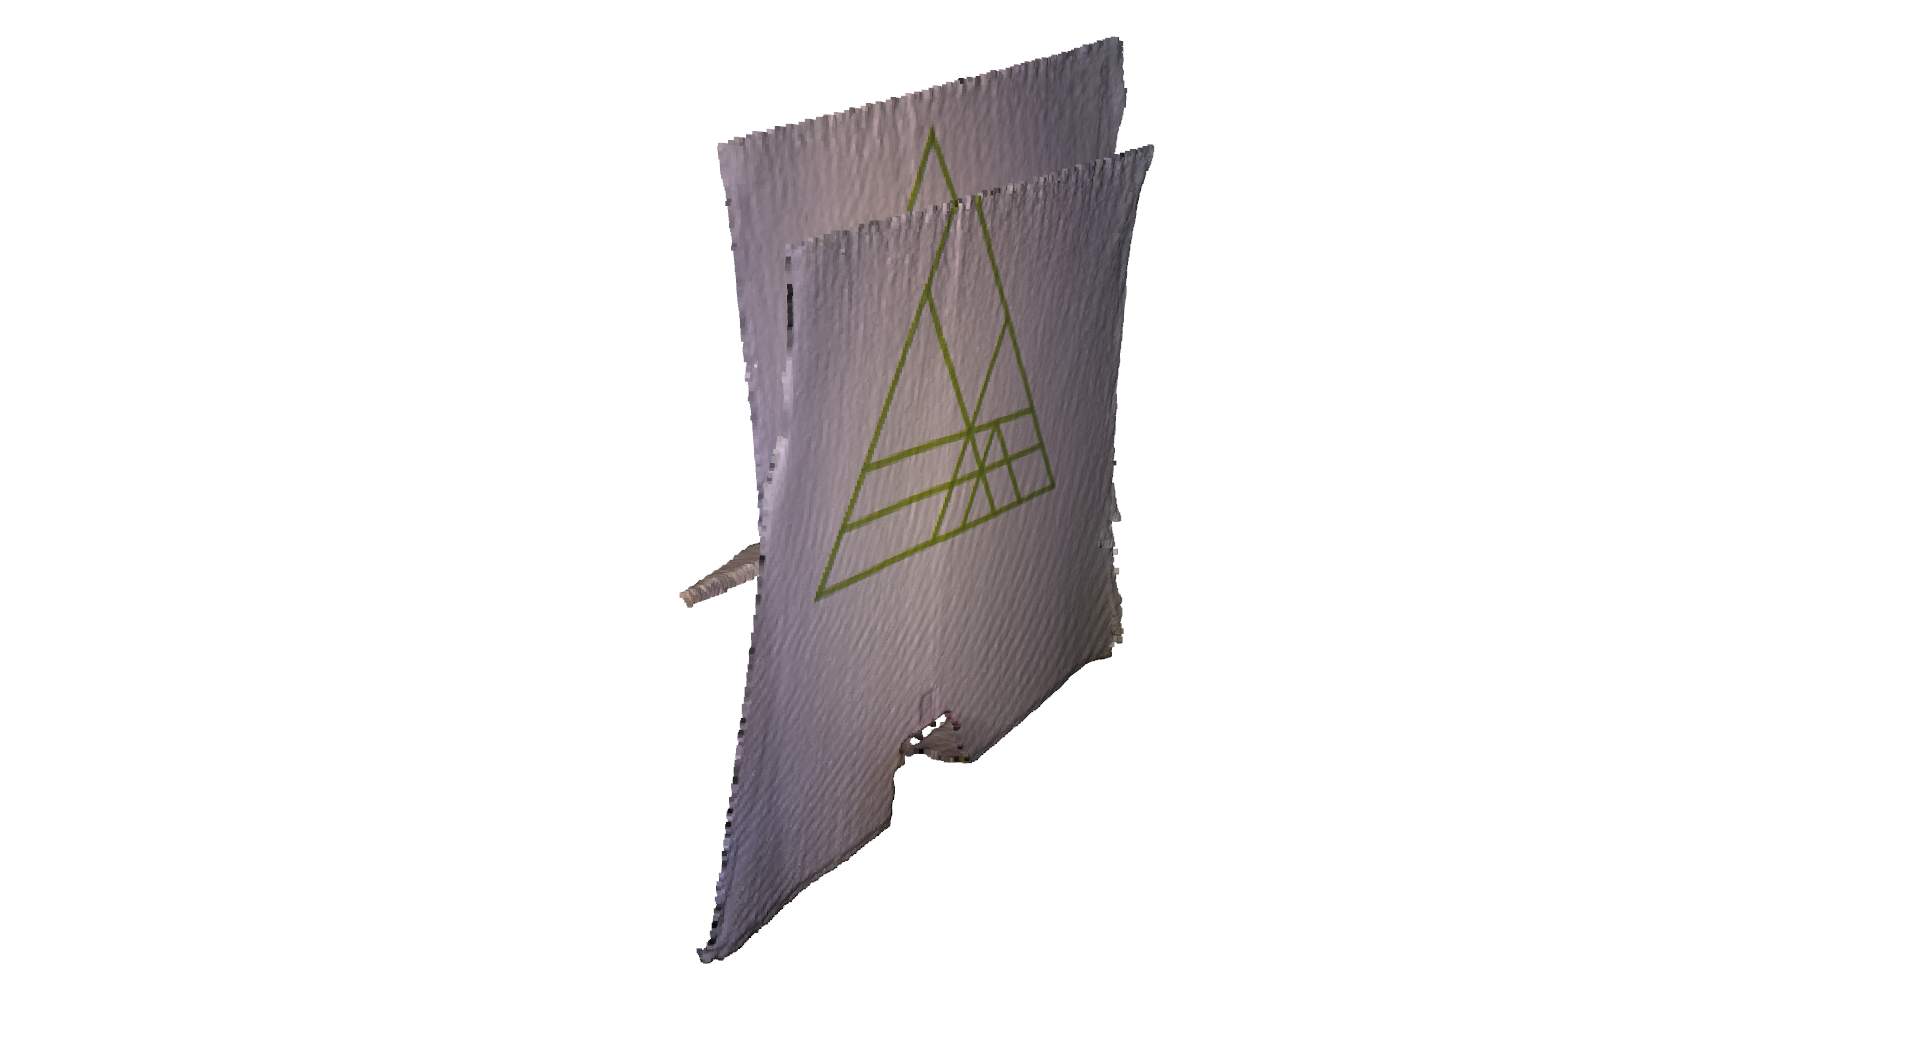

In [7]:
print("1. Load two point clouds and show initial pose")
source = o3d.io.read_point_cloud("Open3D/examples/test_data/ColoredICP/frag_115.ply")
target = o3d.io.read_point_cloud("Open3D/examples/test_data/ColoredICP/frag_116.ply")

# draw initial alignment
current_transformation = np.identity(4)
draw_registration_result_original_color(source, target, current_transformation)

### Point-to-plane ICP
We first run Point-to-Plane ICP as a baseline approach. The visualization below shows misaligned green triangle textures. This is because a geometric constraint does not prevent two planar surfaces from slipping

2. Point-to-Plane ICP registration is applied on original point
   clouds to refine the alignment. Distance threshold 0.02.
RegistrationResult with fitness=9.745825e-01, inlier_rmse=4.220433e-03, and correspondence_set size of 62729
Access transformation to get result.


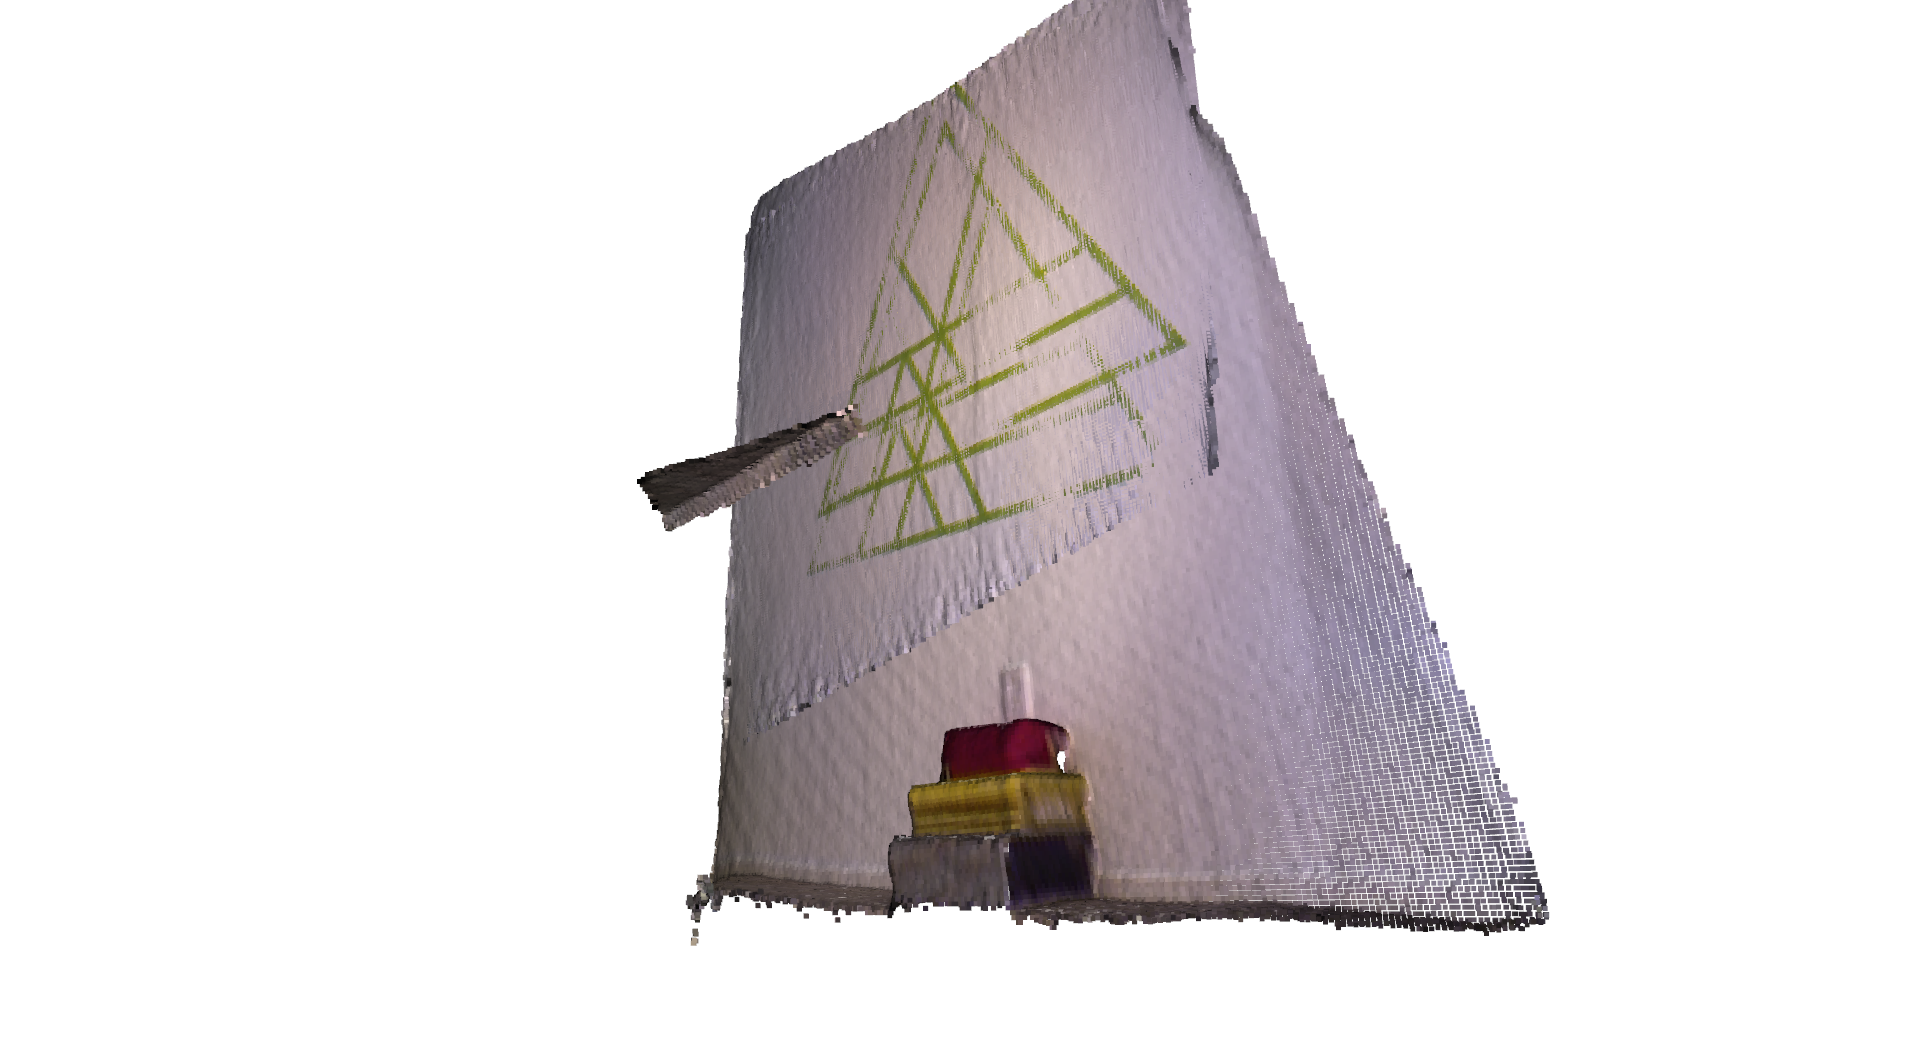

In [7]:
# point to plane ICP
current_transformation = np.identity(4)
print("2. Point-to-Plane ICP registration is applied on original point")
print("   clouds to refine the alignment. Distance threshold 0.02.")
result_icp = o3d.pipelines.registration.registration_icp(source, target, 0.02, current_transformation, 
                                    o3d.pipelines.registration.TransformationEstimationPointToPlane())
print(result_icp)
draw_registration_result_original_color(source, target, result_icp.transformation)

### Colored point cloud registration
The core function for colored point cloud registration is ***registraton_colored_icp***. Following \[**Park2017""\], it runs ICP iterations (see Point-to-point ICP for details) with a joint optimation objective
$$
\mathit{E} (\mathbf{T}) = (1 - \delta)\mathit{E_C}(\mathbf{T}) + \delta\mathit{E_G}(\mathbf{T})
$$

where $\mathbf{T}$ is the transformation matrix to be estimated. $\mathit{E_C}$ and $\mathit{E_G}$ are the photometric and geometric terms, respectively. $\delta \in [0, 1]$ is a weight parameter that has been determined empirically.

The geometric term $\mathit{E_G}$ is the same as the **Point-to-plane ICP** objective
$$
\mathit{E_G}(\mathbf{T}) = \sum_{(\mathbf{p}, \mathbf{q})\in \mathcal{K}} \bigl((\mathbf{p} - \mathbf{T} \mathbf{q})\cdot \mathbf{n_p})^2
$$

where $\mathcal{K}$ is the correspondence set in the current iteration. $\mathbf{n_p}$ is the normal of point $\mathbf{p}$.

The color term $\mathit{E_C}$ measures the difference between the color of point $\mathbf{q}$ (denoted as $C(\mathbf{q}))$ and the color of its projection on the tangent plane of $\mathbf{p}$.
$$
\mathit{E_C}(\mathbf{T}) = \sum_{(\mathbf{p}, \mathbf{q})\in \mathcal{K}} \bigl(\mathit{C}_{\mathbf{p}}(\mathbf{f}(\mathbf{T}\mathbf{q})) - \mathit{C}(\mathbf{q})\bigr)^2
$$

where $C_{\mathbf{p}}(\cdot)$ is a precomputed function continuously defined on the tangent plane of $\mathbf{p}$. Function $\mathbf{f}(\cdot)$ projects a 3D point to the tangent plane. For more details, refer to [Park2017](http://www.open3d.org/docs/release/tutorial/reference.html#park2017).

To further improve efficiency, [Park2017](http://www.open3d.org/docs/release/tutorial/reference.html#park2017) proposes a multi-scale registration scheme. This has been implemented in the following script.

3. Colored point cloud registration
[50, 0.04, 0]
3-1. Downsample with a voxel size 0.04
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=8.763667e-01, inlier_rmse=1.457778e-02, and correspondence_set size of 2084
Access transformation to get result.
[30, 0.02, 1]
3-1. Downsample with a voxel size 0.02
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=8.661842e-01, inlier_rmse=8.759721e-03, and correspondence_set size of 7541
Access transformation to get result.
[14, 0.01, 2]
3-1. Downsample with a voxel size 0.01
3-2. Estimate normal.
3-3. Applying colored point cloud registration
RegistrationResult with fitness=8.437191e-01, inlier_rmse=4.851480e-03, and correspondence_set size of 24737
Access transformation to get result.


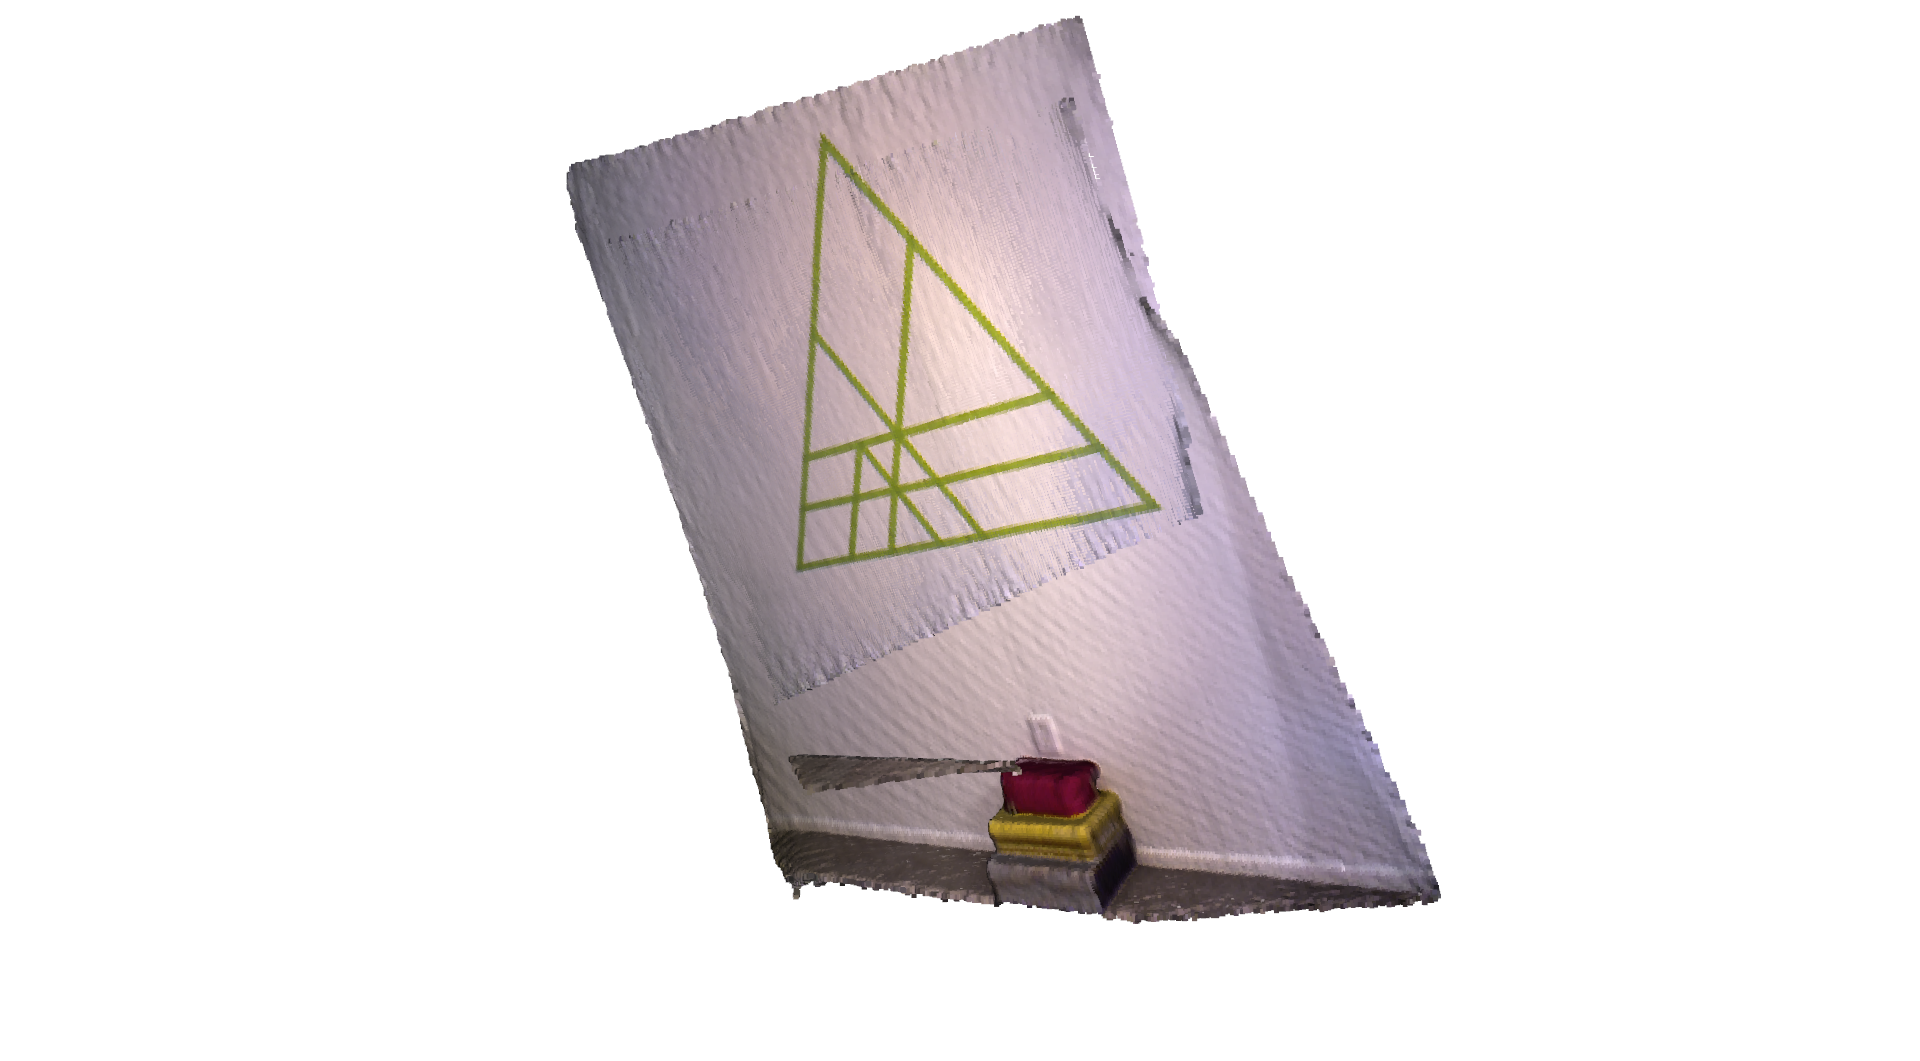

In [8]:
# colored point cloud registration
# This is implementation of following paper
# J. Park, Q. -Y. Zhou, V. Koltun,
# Colored Point Cloud Registration Revisited, ICCV 2017
voxel_radius = [0.04, 0.02, 0.01]
max_iter = [50, 30, 14]
current_transformation = np.identity(4)
print("3. Colored point cloud registration")
for scale in range(3):
    iter = max_iter[scale]
    radius = voxel_radius[scale]
    print([iter, radius, scale])

    print("3-1. Downsample with a voxel size {:.2f}".format(radius))
    source_down = source.voxel_down_sample(radius)
    target_down = target.voxel_down_sample(radius)

    print("3-2. Estimate normal.")
    source_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))
    target_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=radius * 2, max_nn=30))

    print("3-3. Applying colored point cloud registration")
    result_icp = o3d.pipelines.registration.registration_colored_icp(source_down, target_down, radius, current_transformation,
        o3d.pipelines.registration.TransformationEstimationForColoredICP(),
        o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6, relative_rmse=1e-6, max_iteration=iter))
    current_transformation = result_icp.transformation
    print(result_icp)
draw_registration_result_original_color(source, target, result_icp.transformation)

In total, 3 layers of multi-resolution point clouds are created with ***voxel_down_sample***. Normals are computed with vertex normal estimation. The core registration function ***registration_colored_icp*** is called for each layer, from coarse to fine. ***lambda_geometric*** is an optional argument for ***registration_colored_icp*** that determines $\lambda \in [0, 1]$ in the overall energy $\lambda E_G + (1 - \lambda) E_C$.

The output is a tight alignment of the two point clouds. Notice the green triangles on the wall.